# Exam 1

## Portfolio Management

### MLP Training

#### January 2025

Questions?

- Contact: Mark Hendricks
- hendricks@uchicago.edu


---


## Data


All the analysis below applies to the data set,

- `data/exam_1_data.xlsx`
- The file has **weekly** returns for the largest 10 stocks and SPY
- For annualization, use 52 periods per year.


---


# 1. Risk Statistics and Decomposition


### 1.1.


Display a table with the following metrics for each of the return series.

- mean (annualized)
- volatility (annualized)
- Sharpe ratio (annualized)
- skewness
- kurtosis
- maximum drawdown

#### Note

We have total returns, and Sharpe ratio is technically defined for excess returns. Don't worry about the difference.

#### Note

You might consider importing two functions from `cmds/portfolio`: `performanceMetrics` and `maximumDrawdown`. No need to use these, and you may well have implemented these calculations with your own (better) code in `Assignment 1`.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load into dfs
prices = pd.read_excel('../data/exam_1_data.xlsx', 'prices')
prices.index = prices['date']
prices = prices.drop('date', axis=1)

tot_ret  = pd.read_excel('../data/exam_1_data.xlsx', 'total returns')
tot_ret.index = tot_ret['date']
tot_ret = tot_ret.drop('date', axis=1)

In [52]:
# we have weekly data so in order to annualize it we have to multiply by 52
SCALE = 52
mean_ret = tot_ret.mean() * SCALE
mean_ret.name = 'mean'

vol = tot_ret.std() * np.sqrt(SCALE)
vol.name = 'vol'

# sharpe_ratio based on total return instead of excess return
sharpe_ratio = mean_ret / vol
sharpe_ratio.name = 'sharpe ratio'

# sharpe_ratio based on total return instead of excess return
sharpe_ratio = mean_ret / vol
sharpe_ratio.name = 'sharpe ratio'

kurtosis = tot_ret.kurtosis()
kurtosis.name = 'kurtosis'

skewness = tot_ret.skew()
skewness.name = 'skewness'

# drawdown
cum_returns = (1 + tot_ret).cumprod()
rolling_max = cum_returns.cummax()
drawdown = (cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
max_drawdown.name = 'max drawdown'

df = pd.concat([mean_ret, vol, sharpe_ratio, kurtosis, skewness, max_drawdown], axis=1)
df

,mean,vol,sharpe ratio,kurtosis,skewness,max drawdown
AAPL,0.271643,0.270042,1.005930,1.885931,-0.148249,-0.346407
AMZN,0.313481,0.303785,1.031916,1.892582,0.072706,-0.548307
AVGO,0.409931,0.361613,1.133618,3.506986,0.628551,-0.396644
BRK-B,0.129499,0.188231,0.687982,2.719930,-0.236461,-0.264770
GOOGL,0.236442,0.276605,0.854799,4.068113,0.627305,-0.418639
LLY,0.297114,0.271744,1.093361,1.794557,0.263480,-0.221437
META,0.264289,0.348043,0.759356,4.382225,0.073869,-0.760252
MSFT,0.265230,0.236819,1.119971,2.492423,0.013223,-0.350539
NVDA,0.667543,0.454295,1.469404,1.554351,0.386609,-0.659360
SPY,0.137843,0.167777,0.821586,6.437719,-0.575884,-0.318289


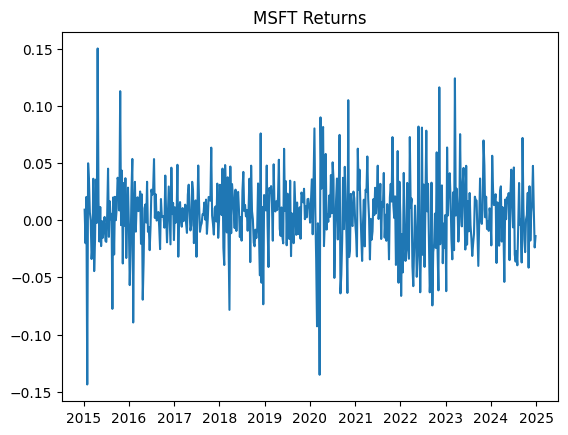

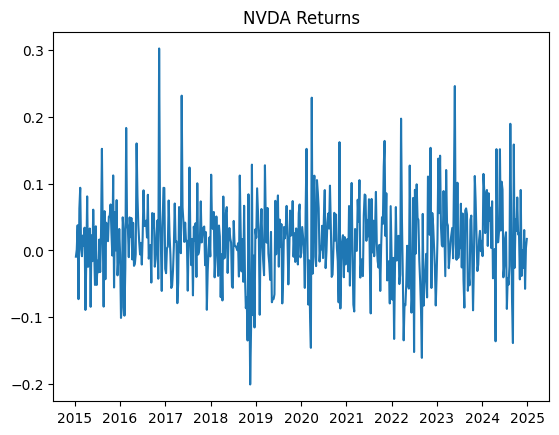

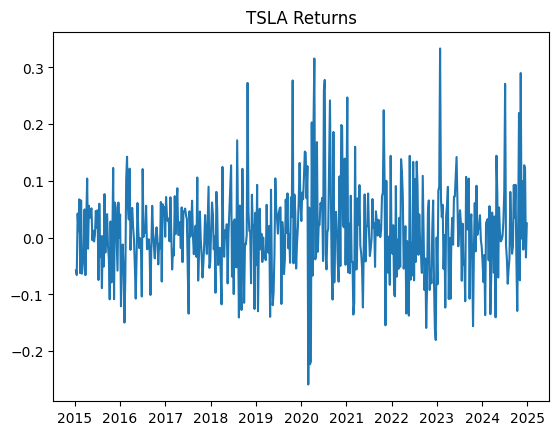

<Figure size 640x480 with 0 Axes>

In [61]:
plt.plot(tot_ret['MSFT'])
plt.title('MSFT Returns')
plt.show()
plt.clf()
plt.plot(tot_ret['NVDA'])
plt.title('NVDA Returns')
plt.show()
plt.clf()
plt.plot(tot_ret['TSLA'])
plt.title('TSLA Returns')
plt.show()
plt.clf()

### 1.2.


As a standalone investment, which is most attractive? And least? Justify your answer.


# Answer

Out of all of these securities, I think the most attractive investment is Microsoft.

As an investor, I like to consider securities that have a sharpe ratio above one. In theory we are getting at least one unit of return per unit of risk we take on. This leaves us with AAPL, AMZN, AVGO, LLY, MSFT, NVDA

Now if I'm maximizing my return per unit of risk I would pick NVDA, but I do not like its max dradown since I can only pick one asset. It is simply to risky. That is why I prefer MSFT. It's sharpe ratio is not as high as NVDA, but since I am in risk management I like its max drawdown a lot better than NVDA's since this is a standalone investment. If we compare MSFT to AVGO, it's sharpe ratio is slightly worse, but MSFT has a significantly better max drawdown as well as less skewness (it is slightly positively skewed at ~0.01. (vs. 0.38 and 0.62).


### 1.3.

For each investment, estimate a regression against `SPY`. Report the

- alpha (annualized as a mean)
- beta
- info ratio
- r-squared

Based on this table, which investment seems most attractive relative to holding `SPY`?

#### Note

You might consider importing two functions from `cmds/portfolio`: `get_ols_metrics`. No need to use it, and you may well have implemented these calculations with your own (better) code in `Assignment 2`.


In [110]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

def get_ols_metrics(regressors, targets, annualization=1, ignorenan=True):
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors, pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets, pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors, how='inner', lsuffix='y ')
    Y = df_aligned[targets.columns]
    Xset = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        
        if ignorenan:
            # ensure we use only non-NaN dates
            alldata = Xset.join(y,lsuffix='X')
            mask = alldata.notnull().all(axis=1)
            y = y[mask]
            X = Xset[mask]
        else:
            X = Xset

        model = LinearRegression().fit(X, y)
        reg.loc[col, 'alpha'] = model.intercept_ * annualization
        reg.loc[col, regressors.columns] = model.coef_
        reg.loc[col, 'r-squared'] = model.score(X, y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit

        num_roundoff = 1e-12
        
        # Treynor Ratio is only defined for univariate regression
        if Xset.shape[1] == 1:
            if np.abs(model.coef_) < num_roundoff:
                reg.loc[col,'Treynor Ratio'] = None
            else:
                reg.loc[col,'Treynor Ratio'] = (y.mean() / model.coef_) * annualization

        
        # if intercept =0, numerical roundoff will nonetheless show nonzero Info Ratio        
        if np.abs(model.intercept_) < num_roundoff:
            reg.loc[col, 'Info Ratio'] = None
        else:
            reg.loc[col, 'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

In [115]:
import statsmodels.api as sm

results = get_ols_metrics(tot_ret['SPY'], tot_ret, SCALE)
results

,alpha,SPY,r-squared,Treynor Ratio,Info Ratio
AAPL,1.193046e-01,1.105160,0.471468,0.245796,0.607701
AMZN,1.696077e-01,1.043745,0.332292,0.300343,0.683260
AVGO,2.321506e-01,1.289728,0.358075,0.317843,0.801279
BRK-B,1.443207e-02,0.834769,0.553626,0.155132,0.114759
GOOGL,8.870470e-02,1.071775,0.422622,0.220608,0.422042
LLY,2.093711e-01,0.636539,0.154453,0.466764,0.837893
META,1.097390e-01,1.121198,0.292122,0.235720,0.374756
MSFT,1.225329e-01,1.035213,0.537889,0.256208,0.761139
NVDA,4.322466e-01,1.706982,0.397418,0.391066,1.225705
SPY,-6.765422e-17,1.000000,1.000000,0.137843,NaN


In [117]:
best_alpha = results['alpha'].idxmax()
best_info_ratio = results['Info Ratio'].idxmax()

best_alpha, best_info_ratio

('NVDA', 'NVDA', 'LLY')

# Answer
The most attractive investment relative to holding SPY is NVDA. This question is asking about which assset is the best relative to holding SPY (the market). We care about the investment which generated the most alpha, returns that are unexplained by SPY/the market. NVDA has the highest alpha out of this group of assets and also has the highest information ratio which means from whichever returns we can attribute to NVDA that were not from the market (SPY), the ratio of actual alpha to residual noise is the highest. (Sharpe ratio for alpha basically)

### 1.4.

Suppose you expect `AAPL` to do well relatively, but you want to hedge broad market risk (`SPY`) and A.I. risk (`NVDA`).

For every $100 in `AAPL`, what should you hold in `SPY` and `NVDA`?


In [120]:
# How much of AAPL moves with SPY and NVDA?
# Create a 2 factor model with SPY and AI Risk
results = get_ols_metrics(tot_ret[['SPY', 'NVDA']], tot_ret['AAPL'], SCALE)
results

,alpha,SPY,NVDA,r-squared,Info Ratio
AAPL,0.087351,0.978974,0.073923,0.480787,0.448917


# Answer
It looks like for every $100 dollars we put into apple, we have to short $97.89 of SPY and short $7.39 of NVDA

### 1.5.

Without estimating anything new, consider the idea of replicating `AAPL` using `SPY`, and `NVDA`. Which regression statistic best indicates if your replication tracks the target well?


---


# Answer
Well we see here that if we try to "explain" AAPL's behavior with SPY and NVDA (our 2 factors), we only get an R-squared of 0.480787. R-squared is a measure of how much the variance of our dependent variable (AAPL returns) can be explained by our independent variables (NVDA and SPY). In this example R-squared is really low so we would have a poor replication.

# 2. Portfolio Allocation


### 2.1.

Display the correlation matrix of the returns.

- Based on this information, which investment do you anticipate will get extra weight in the portfolio, beyond what it would merit for its mean return?

- Report the maximally correlated assets and the minimally correlated assets.


In [129]:
corr = tot_ret.corr()
display(corr)


,AAPL,AMZN,AVGO,BRK-B,GOOGL,LLY,META,MSFT,NVDA,SPY,TSLA
AAPL,1.000000,0.476831,0.519308,0.417003,0.545585,0.216918,0.419841,0.613676,0.507801,0.686635,0.448325
AMZN,0.476831,1.000000,0.367663,0.281910,0.585064,0.167353,0.496040,0.615415,0.514741,0.576448,0.389788
AVGO,0.519308,0.367663,1.000000,0.324900,0.431007,0.175909,0.357989,0.505728,0.558456,0.598394,0.356842
BRK-B,0.417003,0.281910,0.324900,1.000000,0.376896,0.302655,0.290500,0.414376,0.319379,0.744060,0.221381
GOOGL,0.545585,0.585064,0.431007,0.376896,1.000000,0.202863,0.523786,0.654373,0.463963,0.650094,0.350708
LLY,0.216918,0.167353,0.175909,0.302655,0.202863,1.000000,0.160026,0.315593,0.212958,0.393005,0.178095
META,0.419841,0.496040,0.357989,0.290500,0.523786,0.160026,1.000000,0.539839,0.412218,0.540483,0.261607
MSFT,0.613676,0.615415,0.505728,0.414376,0.654373,0.315593,0.539839,1.000000,0.592201,0.733409,0.395818
NVDA,0.507801,0.514741,0.558456,0.319379,0.463963,0.212958,0.412218,0.592201,1.000000,0.630411,0.411362
SPY,0.686635,0.576448,0.598394,0.744060,0.650094,0.393005,0.540483,0.733409,0.630411,1.000000,0.504327


(('BRK-B', 'SPY'), ('LLY', 'META'))

<Axes: >

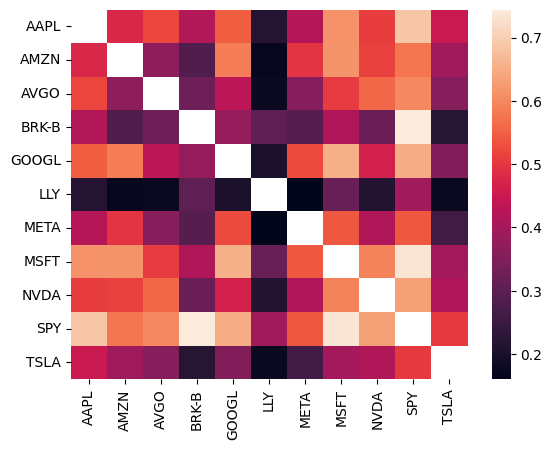

In [130]:
corr[corr == 1] = np.nan
corr_pair = corr.unstack().dropna()
display((corr_pair.idxmax(), corr_pair.idxmin()))
sns.heatmap(corr)


# Answer
Usually the asset that has the smallest amounts of correlation with the other assets will be weighted disproportionately (with respect to its mean return) in the portfolio since it will be a diversifier. In this case it looks like LLY has the lowest correlation consistently with the other assets.

### 2.2.

Calculate the weights of the mean-variance optimized portfolio, also called the tangency portfolio.

- Display a table indexed by each investment, with the optimal weights in one column and the Sharpe ratios in another column.

- Do the investments with the best Sharpe ratios tend to get the biggest weights?

#### Note:

To estimate the optimal weights, consider using the provided function below.


In [157]:
def optimized_weights(returns,dropna=True,scale_cov=1):
    if dropna:
        returns = returns.dropna()

    covmat_full = returns.cov()
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full + (1-scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat,returns.mean())
    weights = weights / weights.sum()

    if returns.mean() @ weights < 0:
        weights = -weights

    return pd.DataFrame(weights, columns=['weight'], index=returns.columns)

In [160]:
tan_weights = optimized_weights(tot_ret) # we consider the case we end up on the undesireable piece of the frontier
final_df = tan_weights.join(sharpe_ratio)
final_df

,weight,sharpe ratio
AAPL,0.510019,1.005930
AMZN,0.446167,1.031916
AVGO,0.571889,1.133618
BRK-B,2.187957,0.687982
GOOGL,0.228139,0.854799
LLY,1.081608,1.093361
META,0.219753,0.759356
MSFT,0.509144,1.119971
NVDA,0.798800,1.469404
SPY,-5.811005,0.821586


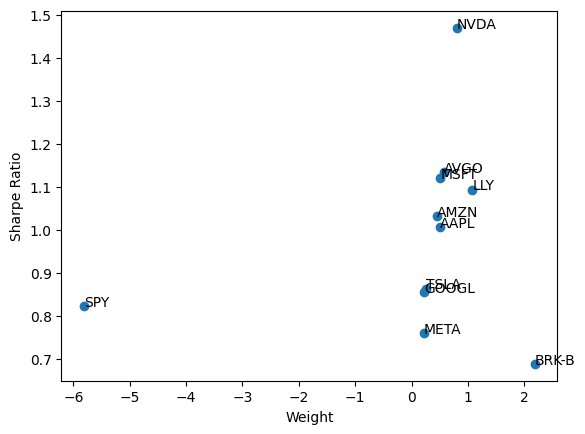

In [172]:
fig, ax = plt.subplots()
ax.scatter(final_df['weight'], final_df['sharpe ratio'])
plt.xlabel('Weight')
plt.ylabel('Sharpe Ratio')
for tick in final_df.index:
    ax.annotate(tick, (final_df['weight'][tick], final_df['sharpe ratio'][tick]))

# Answer
It looks like there are many securities with varying sharpe ratios that share similar weights. So sharpe ratio in a portfolio of assets is not explaining the portfolio weights.

### 2.3.

Report the following performance statistics of the portfolio achieved with the optimized weights calculated above.

- mean
- volatility
- Sharpe

(Annualize all three statistics.)


In [190]:
# calc mean portfolio ret by applying the weights to the security returns and avg
port_ret = tot_ret.dot(tan_weights).rename(columns={'weight':'return'})

port_mean_ret = port_ret.mean() * SCALE
port_mean_ret.name = 'mean return'

port_vol = port_ret.std() * np.sqrt(SCALE)
port_vol.name = 'volatility'

port_sharpe_ratio = port_mean_ret / port_vol
port_sharpe_ratio.name = 'sharpe ratio'

port_stats_df = pd.concat([port_mean_ret, port_vol, port_sharpe_ratio], axis=1)
port_stats_df

,mean return,volatility,sharpe ratio
return,1.227112,0.572067,2.14505


### 2.4.

Briefly explain why the optimized portfolio is unrealistic.


In [192]:
# let's calculate the actual leverage we will need in the portfolio....
tan_weights.abs().sum()

weight    12.622009
dtype: float64

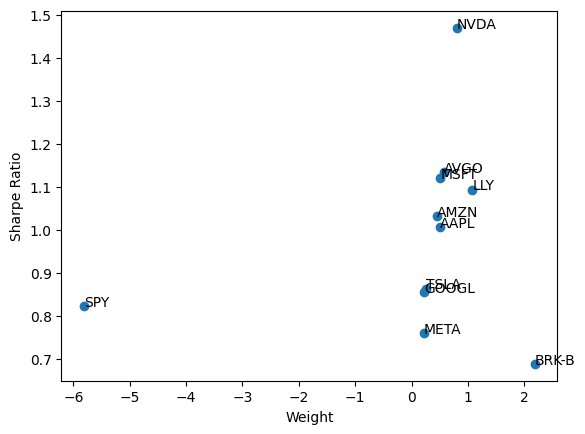

In [191]:
fig, ax = plt.subplots()
ax.scatter(final_df['weight'], final_df['sharpe ratio'])
plt.xlabel('Weight')
plt.ylabel('Sharpe Ratio')
for tick in final_df.index:
    ax.annotate(tick, (final_df['weight'][tick], final_df['sharpe ratio'][tick]))

# Answer
Clearly, we will have to use an insane amount of leverage to get this optimal portfolio. If we sum the absolute values of the weights in our portfolio, we get 12 instead of 1. One position that is very unrealistic is shorting the market (SPY) by more than 500%. Again the problem is not with the mathematics inside of the optimizer, it is a problem with the assumptions we make with our data. The optimizer is being "greedy", it is always finding the most optimal point without any regard for how realistic/unrealistic the weights would be. If it can find the slightest gains by creating some high weights, it will do it. We need to impose some constraints.

### 2.5.

Briefly explain what the optimizer likes about its biggest...

- long position.
- short position.


# Answer
## Short Position
Since most of the securities in our portfolio makeup the SNP 500 index (we have big tech stocks and berkshire hathway), our optimizer prefers to "hedge" away the risk to these assets by heavily shorting the SPY etf, since it is strongly related to AMZN, AAPL, TSLA, GOOGL, META, MSFT, AVGO, etc because at the end of the day we are trying to find that sweet spot (the Mean-Variance frontier)

# Long Position
Now since majority of these securities are blue chip tech stocks which are dependent on the same kinds of factors (supply chains are heavily overlapped/reliant on each other, etc.) they adopt similar kinds of behavior. Because the optimizer is trying to find the best way to diversify these tech stocks, it is using Berkshire Hathway to help that process. Berkshire Hathway is not a tech stock, it is a completely different animal with a completely different risk profile. This makes it the perfect candidate to go heavily long on with the existing weights of the tech stocks.

### 2.6. Extra, not graded.

Try dropping the asset which had the biggest short position from the investment set. Re-run the optimization. What do you think of these new weights compared to the original optimized weights?

What is going on?


In [195]:
tot_ret_ex_SPY = tot_ret.drop('SPY', axis=1)
tan_weights = optimized_weights(tot_ret_ex_SPY) # we consider the case we end up on the undesireable piece of the frontier
ex_SPY_df = tan_weights.join(sharpe_ratio)
ex_SPY_df

,weight,sharpe ratio
AAPL,0.049252,1.005930
AMZN,0.155983,1.031916
AVGO,0.151073,1.133618
BRK-B,-0.043041,0.687982
GOOGL,-0.057048,0.854799
LLY,0.445933,1.093361
META,0.000208,0.759356
MSFT,-0.054585,1.119971
NVDA,0.321344,1.469404
TSLA,0.030882,0.863348


In [196]:
# calc mean portfolio ret by applying the weights to the security returns and avg
port_ret = tot_ret_ex_SPY.dot(tan_weights).rename(columns={'weight':'return'})

port_mean_ret = port_ret.mean() * SCALE
port_mean_ret.name = 'mean return'

port_vol = port_ret.std() * np.sqrt(SCALE)
port_vol.name = 'volatility'

port_sharpe_ratio = port_mean_ret / port_vol
port_sharpe_ratio.name = 'sharpe ratio'

port_stats_df = pd.concat([port_mean_ret, port_vol, port_sharpe_ratio], axis=1)
port_stats_df

,mean return,volatility,sharpe ratio
return,0.453348,0.262508,1.726988


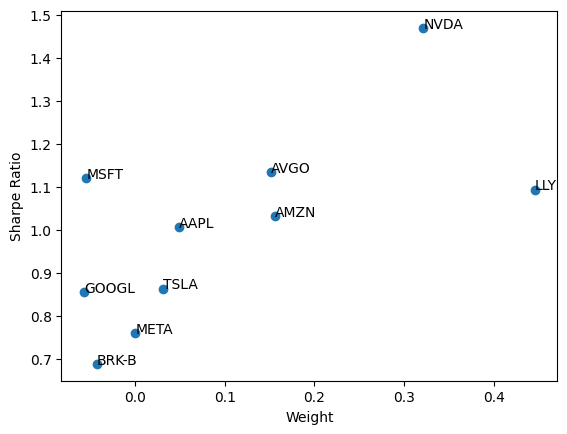

In [200]:
fig, ax = plt.subplots()
ax.scatter(final_df['weight'], final_df['sharpe ratio'])
plt.xlabel('Weight')
plt.ylabel('Sharpe Ratio')
for tick in final_df.index:
    ax.annotate(tick, (final_df['weight'][tick], final_df['sharpe ratio'][tick]))

In [199]:
tan_weights.abs().sum()

weight    1.309349
dtype: float64

# Answer
I think these weights are a lot more realistic. We are not required to have unrealistic amounts of leverage and our largest short position is GOOGL at -0.057. Additionally, we see that weights are more evenly distributed across assets unlike the last time (it was HEAVILY skewed towards shorting SPY and heavily going long BRK-B). This time the weights are more evenly distributed.

---
